In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import pyccl as ccl
import pyccl.nl_pt as pt
import numpy as np
from aemulus_heft.heft_emu import HEFTEmulator
from aemulus_heft.utils import lpt_spectra

plt.rcParams['axes.labelsize']        = 12
plt.rcParams['axes.titlesize']        = 12
plt.rcParams['xtick.labelsize']       = 12
plt.rcParams['ytick.labelsize']       = 12
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.size']             = 12

In [2]:
# picking numbers to create fiducial pgg and pgm
cosmo = ccl.Cosmology(Omega_c=0.25337, Omega_b=0.04933, h=0.68, sigma8=0.82, n_s=0.96, transfer_function='boltzmann_class')
h = 0.68
b_1 = 2
ptt_m = pt.PTMatterTracer()
ptt_g = pt.PTNumberCountsTracer(b1=b_1)
ptc = pt.EulerianPTCalculator(with_NC=True, with_IA=False, log10k_min=-4, log10k_max=2, nk_per_decade=20)
ptc.update_ingredients(cosmo)

pk_gg = ptc.get_biased_pk2d(ptt_g, tracer2=ptt_g)
pk_gm = ptc.get_biased_pk2d(ptt_g, tracer2=ptt_m)

In [3]:
# CCL works in 1/Mpc, convert to h/Mpc
k = np.logspace(-3, 0)
pgg_fid = h**3*pk_gg(k*h, 1/(1+0.633))+1e3
pgm_fid = h**3*pk_gm(k*h, 1/(1+0.633))

In [4]:
def bias_fit(biases, emu, spec_heft):
    phh_dat = pgg_fid
    phm_dat = pgm_fid
    
    phh_fit = emu.basis_to_full(k, biases, spec_heft, cross=False)
    phm_fit = emu.basis_to_full(k, biases, spec_heft, cross=True)

    idx = -4  #k[-4]=0.655
    
    # prioritizing fit to low-k
    chisq = np.sum((phh_dat[:idx]-phh_fit[:idx])**2/(phh_fit[:idx])) + 0.1*np.sum((phm_dat[:idx]-phm_fit[:idx])**2/(phm_fit[:idx])) + \
            np.sum((phh_dat[idx:]-phh_fit[idx:])**2/(k[idx:]**2*phh_fit[idx:])) +  \
            0.1*np.sum((phm_dat[idx:]-phm_fit[idx:])**2/(k[idx:]**2*phm_fit[idx:]))

    return chisq

In [5]:
emu1 = HEFTEmulator()
cosmo = [0.04933*h**2, 0.25337*h**2, -1, 0.96, 2.33, h*100, 0.] #sigma_8 = 0.85
z=0.633

spec_lpt1, sigma8z1 = lpt_spectra(k, z, cosmo)
cosmo.append(sigma8z1)
spec_heft1 = emu1.predict(k, np.array(cosmo), spec_lpt1)

fit = sc.optimize.minimize(bias_fit, x0=[1, 1, 1, 1, 1e3], args=(emu1, spec_heft1))['x']
print('b1, b2, b2, bk2, shotnoise:', fit)

b1, b2, b2, bk2, shotnoise: [ 9.19547822e-01 -6.87599112e-01  6.35565921e-01  9.03119109e-02
  1.12533000e+03]


In [6]:
emu2 = HEFTEmulator()
cosmo2 = [0.04933*h**2, 0.25337*h**2, -1, 0.96, 2.08, h*100, 0.] #sig_8 = 0.8
z=0.633
spec_lpt2, sigma8z2 = lpt_spectra(k, z, cosmo2)
cosmo2.append(sigma8z2)
spec_heft2 = emu2.predict(k, np.array(cosmo2), spec_lpt2)

fit2 = sc.optimize.minimize(bias_fit, x0=[0.7, 0, 0, 0, 1e3], args=(emu2, spec_heft2))['x']
print('b1, b2, b2, bk2, shotnoise:', fit2)

b1, b2, b2, bk2, shotnoise: [ 1.03613840e+00 -3.68090362e-01  6.80450776e-01 -1.62695353e-01
  8.68618042e+02]


In [7]:
emu3 = HEFTEmulator()
cosmo3 = [0.04933*h**2, 0.25337*h**2, -1, 0.96, 1.81, h*100, 0.] #sig_8 = 0.75
z=0.633
spec_lpt3, sigma8z3 = lpt_spectra(k, z, cosmo3)
cosmo3.append(sigma8z3)
spec_heft3 = emu3.predict(k, np.array(cosmo3), spec_lpt3)
fit3 = sc.optimize.minimize(bias_fit, x0=[0.7, 0, 0, 0, 1e3], args=(emu3, spec_heft3))['x']
print('b1, b2, b2, bk2, shotnoise:', fit3)

b1, b2, b2, bk2, shotnoise: [ 1.18888009e+00  4.28939950e-02  6.57324561e-01 -6.08212970e-01
  5.18369677e+02]


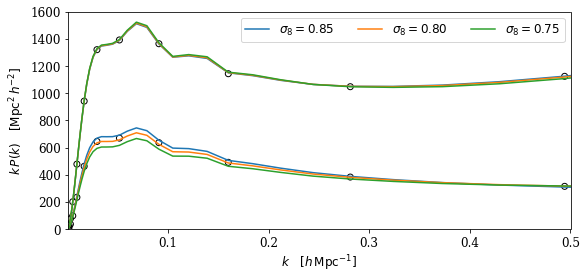

In [8]:
plt.figure(figsize=(9,4))
ds = 4

plt.plot(k, k*emu1.basis_to_full(k, fit, spec_heft1, cross=False))
plt.plot(k, k*emu2.basis_to_full(k, fit2, spec_heft2, cross=False))
plt.plot(k, k*emu3.basis_to_full(k, fit3, spec_heft3, cross=False))

plt.scatter(k[::ds], k[::ds]*pgg_fid[::ds], marker='o', color='k', facecolors='None')
plt.scatter(k[::ds], k[::ds]*pgm_fid[::ds], marker='o', color='k', facecolors='None')

plt.plot(k, k*emu1.basis_to_full(k, fit, spec_heft1, cross=True), c='C0', label=r'$\sigma_8=0.85$')
plt.plot(k, k*emu2.basis_to_full(k, fit2, spec_heft2, cross=True), c='C1', label=r'$\sigma_8=0.80$')
plt.plot(k, k*emu3.basis_to_full(k, fit3, spec_heft3, cross=True), c='C2', label=r'$\sigma_8=0.75$')

plt.xlim(1e-3, 0.5)
plt.ylim(0, 1600)

plt.legend(ncol=3)
plt.xlabel(r'$k\quad[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k\,P(k)\quad[{\rm Mpc}^{2}\,h^{-2}]$')
plt.savefig('figures/fix_sig8.pdf')